In [52]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib

In [ ]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')  #Replace with the file path of EMLforSAI in your system.

In [ ]:
# 1. 读取数据
df=pd.read_csv(r'./Dataset/ML_data.csv')

In [ ]:
# 2. 数据预处理
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']

def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

X = df[feature_columns]
y = df['y_category']

# 3. 设置五折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("=== Optuna贝叶斯优化调参 (随机森林) ===")
print(f"样本数: {len(X)}, 特征数: {len(feature_columns)}")
print(f"类别分布: {dict(y.value_counts().sort_index())}")
print(f"类别比例: {y.value_counts(normalize=True).sort_index().values}")

# 4. 定义Optuna目标函数 (针对随机森林)
def objective(trial):
    """
   Optuna objective function
   return: cross-validation accuracy
    """
    # 定义随机森林参数搜索空间
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) if trial.suggest_categorical('bootstrap', [True, False]) else None,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': 0
    }
    
    # 移除None值的参数
    params = {k: v for k, v in params.items() if v is not None}
    
    # 创建随机森林模型
    model = RandomForestClassifier(**params)
    
    # 使用交叉验证计算分数
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=1)
    
    # 返回平均准确率
    return np.mean(scores)

# 5. 创建Optuna研究并运行优化
print("\n开始Optuna贝叶斯优化...")
study = optuna.create_study(
    direction='maximize',  # 最大化准确率
    sampler=TPESampler(seed=42),  # 使用TPE采样器
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5, interval_steps=1)
)

# 运行优化
n_trials = 100  # 试验次数
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# 6. 输出优化结果
print("\n" + "="*60)
print("Optuna优化结果")
print("="*60)
print(f"最佳试验编号: {study.best_trial.number}")
print(f"最佳准确率: {study.best_value:.4f}")
print(f"最佳参数:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-12-20 14:38:20,095] A new study created in memory with name: no-name-aec5cca5-0c6d-4191-a617-34b67c6a5e39


=== Optuna贝叶斯优化调参 (随机森林) ===
样本数: 687, 特征数: 13
类别分布: {0: 148, 1: 289, 2: 250}
类别比例: [0.2154294  0.42066958 0.36390102]

开始Optuna贝叶斯优化...


Best trial: 0. Best value: 0.810864:   1%|          | 1/100 [00:02<04:11,  2.54s/it]

[I 2025-12-20 14:38:22,633] Trial 0 finished with value: 0.8108642758912514 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None, 'min_impurity_decrease': 0.018182496720710064, 'max_samples': 0.5917022549267169}. Best is trial 0 with value: 0.8108642758912514.


Best trial: 1. Best value: 0.812303:   2%|▏         | 2/100 [00:03<02:45,  1.69s/it]

[I 2025-12-20 14:38:23,724] Trial 1 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 187, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.06075448519014384}. Best is trial 1 with value: 0.8123029726012906.


Best trial: 2. Best value: 0.815212:   3%|▎         | 3/100 [00:04<02:11,  1.36s/it]

[I 2025-12-20 14:38:24,691] Trial 2 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 126, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0662522284353982, 'max_samples': 0.6558555380447055}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 2. Best value: 0.815212:   4%|▍         | 4/100 [00:05<02:06,  1.31s/it]

[I 2025-12-20 14:38:25,939] Trial 3 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 284, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.02713490317738959}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 2. Best value: 0.815212:   5%|▌         | 5/100 [00:07<02:11,  1.38s/it]

[I 2025-12-20 14:38:27,441] Trial 4 finished with value: 0.8137839839204485 and parameters: {'n_estimators': 423, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None, 'min_impurity_decrease': 0.07712703466859458, 'max_samples': 0.5370223258670452}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 2. Best value: 0.815212:   6%|▌         | 6/100 [00:08<02:04,  1.32s/it]

[I 2025-12-20 14:38:28,648] Trial 5 finished with value: 0.8108536972389718 and parameters: {'n_estimators': 211, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.07607850486168975}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 2. Best value: 0.815212:   7%|▋         | 7/100 [00:09<02:03,  1.32s/it]

[I 2025-12-20 14:38:29,971] Trial 6 finished with value: 0.807923410557495 and parameters: {'n_estimators': 303, 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None, 'min_impurity_decrease': 0.07555511385430487}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 2. Best value: 0.815212:   8%|▊         | 8/100 [00:10<01:54,  1.24s/it]

[I 2025-12-20 14:38:31,047] Trial 7 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 153, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.03180034749718639, 'max_samples': 0.5550259622638384}. Best is trial 2 with value: 0.8152121019782079.


Best trial: 8. Best value: 0.815233:   9%|▉         | 9/100 [00:12<01:48,  1.19s/it]

[I 2025-12-20 14:38:32,123] Trial 8 finished with value: 0.8152332592827675 and parameters: {'n_estimators': 152, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.0363629602379294, 'max_samples': 0.9858910413604803}. Best is trial 8 with value: 0.8152332592827675.


Best trial: 8. Best value: 0.815233:  10%|█         | 10/100 [00:13<02:02,  1.36s/it]

[I 2025-12-20 14:38:33,868] Trial 9 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 484, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.09856504541106008, 'max_samples': 0.6210276357557503}. Best is trial 8 with value: 0.8152332592827675.


Best trial: 8. Best value: 0.815233:  11%|█         | 11/100 [00:14<01:45,  1.19s/it]

[I 2025-12-20 14:38:34,668] Trial 10 finished with value: 0.8108536972389718 and parameters: {'n_estimators': 61, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.006564997954247833, 'max_samples': 0.9961813327301687}. Best is trial 8 with value: 0.8152332592827675.


Best trial: 8. Best value: 0.815233:  12%|█▏        | 12/100 [00:15<01:36,  1.09s/it]

[I 2025-12-20 14:38:35,540] Trial 11 finished with value: 0.8137416693113296 and parameters: {'n_estimators': 64, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.04866271471400664, 'max_samples': 0.8229282203516205}. Best is trial 8 with value: 0.8152332592827675.


Best trial: 12. Best value: 0.818142:  13%|█▎        | 13/100 [00:16<01:34,  1.08s/it]

[I 2025-12-20 14:38:36,592] Trial 12 finished with value: 0.8181423886596848 and parameters: {'n_estimators': 127, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.05142229231731888, 'max_samples': 0.7574852070104716}. Best is trial 12 with value: 0.8181423886596848.


Best trial: 12. Best value: 0.818142:  14%|█▍        | 14/100 [00:17<01:30,  1.05s/it]

[I 2025-12-20 14:38:37,561] Trial 13 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 124, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.041105033081477976, 'max_samples': 0.8690491710631163}. Best is trial 12 with value: 0.8181423886596848.


Best trial: 12. Best value: 0.818142:  15%|█▌        | 15/100 [00:18<01:39,  1.17s/it]

[I 2025-12-20 14:38:39,000] Trial 14 finished with value: 0.8122923939490109 and parameters: {'n_estimators': 334, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.042350703058134126, 'max_samples': 0.9585039992795433}. Best is trial 12 with value: 0.8181423886596848.


Best trial: 15. Best value: 0.821041:  16%|█▌        | 16/100 [00:19<01:32,  1.10s/it]

[I 2025-12-20 14:38:39,947] Trial 15 finished with value: 0.8210409393843225 and parameters: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.056251285702534154, 'max_samples': 0.7273982670739538}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  17%|█▋        | 17/100 [00:20<01:23,  1.01s/it]

[I 2025-12-20 14:38:40,744] Trial 16 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.058891334289994005, 'max_samples': 0.7227353551544012}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  18%|█▊        | 18/100 [00:21<01:31,  1.11s/it]

[I 2025-12-20 14:38:42,091] Trial 17 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 239, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.09392843324491532, 'max_samples': 0.7414243232306961}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  19%|█▉        | 19/100 [00:22<01:25,  1.06s/it]

[I 2025-12-20 14:38:43,030] Trial 18 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 112, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.051914720593279146}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  20%|██        | 20/100 [00:23<01:22,  1.03s/it]

[I 2025-12-20 14:38:43,980] Trial 19 finished with value: 0.8108325399344123 and parameters: {'n_estimators': 98, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None, 'min_impurity_decrease': 0.0863340106625782, 'max_samples': 0.8079442944347558}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  21%|██        | 21/100 [00:25<01:31,  1.15s/it]

[I 2025-12-20 14:38:45,432] Trial 20 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 344, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.050914544210843855, 'max_samples': 0.6682129778871433}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  22%|██▏       | 22/100 [00:26<01:22,  1.05s/it]

[I 2025-12-20 14:38:46,245] Trial 21 finished with value: 0.8123135512535702 and parameters: {'n_estimators': 57, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.060370819517264696, 'max_samples': 0.7203189168722419}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  23%|██▎       | 23/100 [00:27<01:21,  1.06s/it]

[I 2025-12-20 14:38:47,338] Trial 22 finished with value: 0.8181106527028457 and parameters: {'n_estimators': 173, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0650267281461141, 'max_samples': 0.7794563999534492}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  24%|██▍       | 24/100 [00:28<01:22,  1.08s/it]

[I 2025-12-20 14:38:48,455] Trial 23 finished with value: 0.8166613773405269 and parameters: {'n_estimators': 159, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.06783116271392198, 'max_samples': 0.7938971668145597}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  25%|██▌       | 25/100 [00:29<01:27,  1.17s/it]

[I 2025-12-20 14:38:49,825] Trial 24 finished with value: 0.8137628266158892 and parameters: {'n_estimators': 248, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.06952520334821291, 'max_samples': 0.8654999282136745}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  26%|██▌       | 26/100 [00:30<01:25,  1.15s/it]

[I 2025-12-20 14:38:50,950] Trial 25 finished with value: 0.8181212313551253 and parameters: {'n_estimators': 188, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.051374629398738964, 'max_samples': 0.6873554043571761}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  27%|██▋       | 27/100 [00:31<01:19,  1.10s/it]

[I 2025-12-20 14:38:51,908] Trial 26 finished with value: 0.8108536972389718 and parameters: {'n_estimators': 95, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.021857985220270916}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  28%|██▊       | 28/100 [00:32<01:20,  1.12s/it]

[I 2025-12-20 14:38:53,090] Trial 27 finished with value: 0.8166613773405269 and parameters: {'n_estimators': 194, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.05440527905316445, 'max_samples': 0.6726557526241925}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  29%|██▉       | 29/100 [00:33<01:17,  1.09s/it]

[I 2025-12-20 14:38:54,092] Trial 28 finished with value: 0.8079339892097748 and parameters: {'n_estimators': 133, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None, 'min_impurity_decrease': 0.042273256377824406, 'max_samples': 0.6974452215641858}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  30%|███       | 30/100 [00:35<01:19,  1.14s/it]

[I 2025-12-20 14:38:55,353] Trial 29 finished with value: 0.8166825346450862 and parameters: {'n_estimators': 223, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.0020193818149296036, 'max_samples': 0.7579979396109574}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  31%|███       | 31/100 [00:36<01:13,  1.06s/it]

[I 2025-12-20 14:38:56,243] Trial 30 finished with value: 0.8137522479636093 and parameters: {'n_estimators': 81, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None, 'min_impurity_decrease': 0.01494649566999301, 'max_samples': 0.6217499111163414}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  32%|███▏      | 32/100 [00:37<01:14,  1.10s/it]

[I 2025-12-20 14:38:57,412] Trial 31 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 178, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.045955609463407376, 'max_samples': 0.7658486519402976}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  33%|███▎      | 33/100 [00:38<01:13,  1.10s/it]

[I 2025-12-20 14:38:58,523] Trial 32 finished with value: 0.8166613773405269 and parameters: {'n_estimators': 176, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.05614338389337236, 'max_samples': 0.86954509646958}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  34%|███▍      | 34/100 [00:39<01:18,  1.19s/it]

[I 2025-12-20 14:38:59,920] Trial 33 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 257, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.06527182022848402, 'max_samples': 0.7853352541245197}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  35%|███▌      | 35/100 [00:40<01:14,  1.14s/it]

[I 2025-12-20 14:39:00,950] Trial 34 finished with value: 0.8108536972389718 and parameters: {'n_estimators': 142, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.06301002618404965}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  36%|███▌      | 36/100 [00:42<01:14,  1.16s/it]

[I 2025-12-20 14:39:02,141] Trial 35 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 204, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0368357549481775, 'max_samples': 0.8304413839791787}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  37%|███▋      | 37/100 [00:43<01:09,  1.11s/it]

[I 2025-12-20 14:39:03,137] Trial 36 finished with value: 0.8166613773405267 and parameters: {'n_estimators': 107, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.08449935990825816, 'max_samples': 0.6979311492524434}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  38%|███▊      | 38/100 [00:44<01:08,  1.11s/it]

[I 2025-12-20 14:39:04,246] Trial 37 finished with value: 0.8093938432243732 and parameters: {'n_estimators': 175, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.07089259599826937}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  39%|███▉      | 39/100 [00:45<01:11,  1.16s/it]

[I 2025-12-20 14:39:05,541] Trial 38 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.08308009223013002, 'max_samples': 0.5945936491235962}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  40%|████      | 40/100 [00:46<01:11,  1.19s/it]

[I 2025-12-20 14:39:06,776] Trial 39 finished with value: 0.8035861631228182 and parameters: {'n_estimators': 222, 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None, 'min_impurity_decrease': 0.057288086177552655, 'max_samples': 0.9116612821748831}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  41%|████      | 41/100 [00:47<01:05,  1.11s/it]

[I 2025-12-20 14:39:07,696] Trial 40 finished with value: 0.8093938432243732 and parameters: {'n_estimators': 88, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.07313611893584099}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  42%|████▏     | 42/100 [00:48<01:06,  1.15s/it]

[I 2025-12-20 14:39:08,958] Trial 41 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 227, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.02728334511216244, 'max_samples': 0.754929409537076}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  43%|████▎     | 43/100 [00:50<01:06,  1.16s/it]

[I 2025-12-20 14:39:10,146] Trial 42 finished with value: 0.8152332592827675 and parameters: {'n_estimators': 204, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.005223711624268651, 'max_samples': 0.7744439933860179}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  44%|████▍     | 44/100 [00:51<01:03,  1.14s/it]

[I 2025-12-20 14:39:11,224] Trial 43 finished with value: 0.8137628266158892 and parameters: {'n_estimators': 153, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.04756738645686524, 'max_samples': 0.7380969815758577}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 15. Best value: 0.821041:  45%|████▌     | 45/100 [00:52<01:07,  1.22s/it]

[I 2025-12-20 14:39:12,640] Trial 44 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 267, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.03434139787651913, 'max_samples': 0.7083246206178644}. Best is trial 15 with value: 0.8210409393843225.


Best trial: 45. Best value: 0.821052:  46%|████▌     | 46/100 [00:53<01:01,  1.14s/it]

[I 2025-12-20 14:39:13,596] Trial 45 finished with value: 0.8210515180366021 and parameters: {'n_estimators': 118, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.0004503647292943354, 'max_samples': 0.6475292166083026}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  47%|████▋     | 47/100 [00:54<00:58,  1.11s/it]

[I 2025-12-20 14:39:14,642] Trial 46 finished with value: 0.8181212313551253 and parameters: {'n_estimators': 124, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.06237421380953812, 'max_samples': 0.6406840792895764}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  48%|████▊     | 48/100 [00:55<00:55,  1.06s/it]

[I 2025-12-20 14:39:15,594] Trial 47 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 123, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.05329192723584333, 'max_samples': 0.6237372419206979}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  49%|████▉     | 49/100 [00:56<00:52,  1.02s/it]

[I 2025-12-20 14:39:16,516] Trial 48 finished with value: 0.8137522479636095 and parameters: {'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.045078163802052, 'max_samples': 0.5686212648712049}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  50%|█████     | 50/100 [00:57<00:49,  1.00it/s]

[I 2025-12-20 14:39:17,467] Trial 49 finished with value: 0.8210409393843225 and parameters: {'n_estimators': 121, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.012034223370659472, 'max_samples': 0.6418908388111724}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  51%|█████     | 51/100 [00:58<00:47,  1.04it/s]

[I 2025-12-20 14:39:18,346] Trial 50 finished with value: 0.8035544271659789 and parameters: {'n_estimators': 70, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.016410521153970126}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  52%|█████▏    | 52/100 [00:59<00:46,  1.04it/s]

[I 2025-12-20 14:39:19,297] Trial 51 finished with value: 0.8181212313551253 and parameters: {'n_estimators': 119, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.010906312989848312, 'max_samples': 0.5151801223189528}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  53%|█████▎    | 53/100 [01:00<00:46,  1.02it/s]

[I 2025-12-20 14:39:20,331] Trial 52 finished with value: 0.8166507986882472 and parameters: {'n_estimators': 137, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.009352689365852193, 'max_samples': 0.6389947766686156}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  54%|█████▍    | 54/100 [01:01<00:45,  1.02it/s]

[I 2025-12-20 14:39:21,304] Trial 53 finished with value: 0.8123029726012906 and parameters: {'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.0018656054118208374, 'max_samples': 0.6546914202438151}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  55%|█████▌    | 55/100 [01:02<00:45,  1.00s/it]

[I 2025-12-20 14:39:22,366] Trial 54 finished with value: 0.8123135512535702 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.021322725516443257, 'max_samples': 0.5942516590653646}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  56%|█████▌    | 56/100 [01:04<00:55,  1.25s/it]

[I 2025-12-20 14:39:24,196] Trial 55 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.03970365641012648, 'max_samples': 0.6753841933497163}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  57%|█████▋    | 57/100 [01:05<00:56,  1.32s/it]

[I 2025-12-20 14:39:25,669] Trial 56 finished with value: 0.8137522479636095 and parameters: {'n_estimators': 405, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.05949936061527537, 'max_samples': 0.6498125625260389}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  58%|█████▊    | 58/100 [01:06<00:49,  1.19s/it]

[I 2025-12-20 14:39:26,557] Trial 57 finished with value: 0.8152015233259282 and parameters: {'n_estimators': 76, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.05041903994368869, 'max_samples': 0.6793698029366313}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  59%|█████▉    | 59/100 [01:07<00:45,  1.11s/it]

[I 2025-12-20 14:39:27,498] Trial 58 finished with value: 0.8123347085581297 and parameters: {'n_estimators': 115, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None, 'min_impurity_decrease': 0.02768860777839097, 'max_samples': 0.5624025948382164}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  60%|██████    | 60/100 [01:08<00:44,  1.11s/it]

[I 2025-12-20 14:39:28,612] Trial 59 finished with value: 0.8123135512535702 and parameters: {'n_estimators': 161, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.07841345288886663, 'max_samples': 0.7251006320428433}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  61%|██████    | 61/100 [01:09<00:42,  1.08s/it]

[I 2025-12-20 14:39:29,615] Trial 60 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 129, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.06334008705890767, 'max_samples': 0.691222409179004}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  62%|██████▏   | 62/100 [01:10<00:39,  1.04s/it]

[I 2025-12-20 14:39:30,565] Trial 61 finished with value: 0.8166507986882472 and parameters: {'n_estimators': 116, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.010372215864967052, 'max_samples': 0.5408308389284897}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  63%|██████▎   | 63/100 [01:11<00:35,  1.03it/s]

[I 2025-12-20 14:39:31,365] Trial 62 finished with value: 0.8137734052681689 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.013174966958780109, 'max_samples': 0.5199069781378973}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  64%|██████▍   | 64/100 [01:12<00:34,  1.05it/s]

[I 2025-12-20 14:39:32,290] Trial 63 finished with value: 0.8108325399344123 and parameters: {'n_estimators': 91, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.006304646038186824, 'max_samples': 0.6009129140007525}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  65%|██████▌   | 65/100 [01:13<00:33,  1.04it/s]

[I 2025-12-20 14:39:33,257] Trial 64 finished with value: 0.8166613773405269 and parameters: {'n_estimators': 104, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.018986249939111667, 'max_samples': 0.6419760087655452}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  66%|██████▌   | 66/100 [01:14<00:33,  1.02it/s]

[I 2025-12-20 14:39:34,288] Trial 65 finished with value: 0.8137522479636095 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.00039282482563085313, 'max_samples': 0.5168006216662959}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  67%|██████▋   | 67/100 [01:15<00:31,  1.06it/s]

[I 2025-12-20 14:39:35,136] Trial 66 finished with value: 0.8137522479636093 and parameters: {'n_estimators': 69, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_impurity_decrease': 0.010992456923428942, 'max_samples': 0.6129083784833975}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  68%|██████▊   | 68/100 [01:16<00:31,  1.00it/s]

[I 2025-12-20 14:39:36,256] Trial 67 finished with value: 0.8108325399344123 and parameters: {'n_estimators': 190, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None, 'min_impurity_decrease': 0.054235605106341116, 'max_samples': 0.5803987535707872}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  69%|██████▉   | 69/100 [01:17<00:31,  1.03s/it]

[I 2025-12-20 14:39:37,369] Trial 68 finished with value: 0.810843118586692 and parameters: {'n_estimators': 167, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'min_impurity_decrease': 0.04933749886523256}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  70%|███████   | 70/100 [01:18<00:30,  1.01s/it]

[I 2025-12-20 14:39:38,322] Trial 69 finished with value: 0.8195916640220036 and parameters: {'n_estimators': 118, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.004332849408798221, 'max_samples': 0.5018081358640742}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  71%|███████   | 71/100 [01:19<00:29,  1.03s/it]

[I 2025-12-20 14:39:39,398] Trial 70 finished with value: 0.8181423886596846 and parameters: {'n_estimators': 147, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0036821905784554967, 'max_samples': 0.7339440229326124}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 45. Best value: 0.821052:  72%|███████▏  | 72/100 [01:20<00:28,  1.03s/it]

[I 2025-12-20 14:39:40,446] Trial 71 finished with value: 0.8181318100074051 and parameters: {'n_estimators': 144, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0050345514267689274, 'max_samples': 0.6681574879769792}. Best is trial 45 with value: 0.8210515180366021.


Best trial: 72. Best value: 0.822501:  73%|███████▎  | 73/100 [01:21<00:28,  1.04s/it]

[I 2025-12-20 14:39:41,498] Trial 72 finished with value: 0.8225007933989209 and parameters: {'n_estimators': 142, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.003978894545249695, 'max_samples': 0.7252137706123029}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  74%|███████▍  | 74/100 [01:22<00:26,  1.04s/it]

[I 2025-12-20 14:39:42,532] Trial 73 finished with value: 0.8210409393843225 and parameters: {'n_estimators': 139, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.004460845890766443, 'max_samples': 0.7141361999769397}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  75%|███████▌  | 75/100 [01:23<00:28,  1.15s/it]

[I 2025-12-20 14:39:43,957] Trial 74 finished with value: 0.816682534645086 and parameters: {'n_estimators': 325, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0031514123394251574, 'max_samples': 0.7369308167334844}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  76%|███████▌  | 76/100 [01:24<00:26,  1.09s/it]

[I 2025-12-20 14:39:44,913] Trial 75 finished with value: 0.8166825346450862 and parameters: {'n_estimators': 96, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.007215891716452173, 'max_samples': 0.7996445258938645}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  77%|███████▋  | 77/100 [01:25<00:25,  1.10s/it]

[I 2025-12-20 14:39:46,023] Trial 76 finished with value: 0.8152332592827672 and parameters: {'n_estimators': 159, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.00017927439966347603, 'max_samples': 0.7196930752880072}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  78%|███████▊  | 78/100 [01:26<00:23,  1.08s/it]

[I 2025-12-20 14:39:47,056] Trial 77 finished with value: 0.8152226806304878 and parameters: {'n_estimators': 138, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.008006423125679365, 'max_samples': 0.7519818503753597}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  79%|███████▉  | 79/100 [01:27<00:21,  1.05s/it]

[I 2025-12-20 14:39:48,024] Trial 78 finished with value: 0.8196022426742833 and parameters: {'n_estimators': 105, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.004085515352084897, 'max_samples': 0.8174627269218094}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  80%|████████  | 80/100 [01:28<00:20,  1.04s/it]

[I 2025-12-20 14:39:49,052] Trial 79 finished with value: 0.8050248598328572 and parameters: {'n_estimators': 110, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.019029429298417007}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  81%|████████  | 81/100 [01:29<00:18,  1.00it/s]

[I 2025-12-20 14:39:49,943] Trial 80 finished with value: 0.8152015233259284 and parameters: {'n_estimators': 82, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.013782842563222238, 'max_samples': 0.8307264925805294}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  82%|████████▏ | 82/100 [01:30<00:17,  1.01it/s]

[I 2025-12-20 14:39:50,915] Trial 81 finished with value: 0.8196022426742833 and parameters: {'n_estimators': 103, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.003293696409291929, 'max_samples': 0.7047126568607929}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  83%|████████▎ | 83/100 [01:31<00:16,  1.06it/s]

[I 2025-12-20 14:39:51,761] Trial 82 finished with value: 0.8181318100074051 and parameters: {'n_estimators': 63, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.004124417341387337, 'max_samples': 0.7080415151280727}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  84%|████████▍ | 84/100 [01:32<00:15,  1.05it/s]

[I 2025-12-20 14:39:52,730] Trial 83 finished with value: 0.8108536972389718 and parameters: {'n_estimators': 95, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.008522528842829169, 'max_samples': 0.8142686492541352}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  85%|████████▌ | 85/100 [01:33<00:14,  1.05it/s]

[I 2025-12-20 14:39:53,697] Trial 84 finished with value: 0.8181423886596846 and parameters: {'n_estimators': 122, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0023064154914235833, 'max_samples': 0.7725481715372398}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  86%|████████▌ | 86/100 [01:34<00:13,  1.03it/s]

[I 2025-12-20 14:39:54,697] Trial 85 finished with value: 0.8196022426742833 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 3.257466690971284e-05, 'max_samples': 0.7088090306719593}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  87%|████████▋ | 87/100 [01:35<00:12,  1.02it/s]

[I 2025-12-20 14:39:55,717] Trial 86 finished with value: 0.8181529673119645 and parameters: {'n_estimators': 133, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.006096876708471036, 'max_samples': 0.7049934047628424}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  88%|████████▊ | 88/100 [01:36<00:11,  1.02it/s]

[I 2025-12-20 14:39:56,691] Trial 87 finished with value: 0.8093832645720935 and parameters: {'n_estimators': 105, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.011656365250645501, 'max_samples': 0.8542782207717706}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  89%|████████▉ | 89/100 [01:37<00:10,  1.05it/s]

[I 2025-12-20 14:39:57,581] Trial 88 finished with value: 0.8195916640220036 and parameters: {'n_estimators': 74, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0005049948670846527, 'max_samples': 0.7197938936205988}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  90%|█████████ | 90/100 [01:39<00:11,  1.17s/it]

[I 2025-12-20 14:39:59,258] Trial 89 finished with value: 0.8079339892097746 and parameters: {'n_estimators': 434, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.01470413403321508, 'max_samples': 0.8963567257753099}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 72. Best value: 0.822501:  91%|█████████ | 91/100 [01:40<00:09,  1.10s/it]

[I 2025-12-20 14:40:00,195] Trial 90 finished with value: 0.8152121019782079 and parameters: {'n_estimators': 87, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.01663147683774308, 'max_samples': 0.6865657807340394}. Best is trial 72 with value: 0.8225007933989209.


Best trial: 91. Best value: 0.823961:  92%|█████████▏| 92/100 [01:40<00:08,  1.04s/it]

[I 2025-12-20 14:40:01,083] Trial 91 finished with value: 0.8239606474135195 and parameters: {'n_estimators': 76, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 8.888128483907319e-05, 'max_samples': 0.7159196249529001}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  93%|█████████▎| 93/100 [01:41<00:07,  1.02s/it]

[I 2025-12-20 14:40:02,055] Trial 92 finished with value: 0.8181423886596846 and parameters: {'n_estimators': 101, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0037231803822640615, 'max_samples': 0.7429434773109727}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  94%|█████████▍| 94/100 [01:42<00:05,  1.00it/s]

[I 2025-12-20 14:40:03,009] Trial 93 finished with value: 0.8152438379350471 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 5.265110382494808e-05, 'max_samples': 0.6649503039429302}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  95%|█████████▌| 95/100 [01:43<00:04,  1.06it/s]

[I 2025-12-20 14:40:03,823] Trial 94 finished with value: 0.8108642758912514 and parameters: {'n_estimators': 58, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.008296452449817686, 'max_samples': 0.7597525283607035}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  96%|█████████▌| 96/100 [01:44<00:03,  1.04it/s]

[I 2025-12-20 14:40:04,820] Trial 95 finished with value: 0.8196128213265629 and parameters: {'n_estimators': 123, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0055414926914394876, 'max_samples': 0.7160346301742364}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  97%|█████████▋| 97/100 [01:45<00:02,  1.03it/s]

[I 2025-12-20 14:40:05,805] Trial 96 finished with value: 0.8195916640220036 and parameters: {'n_estimators': 126, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.006266245928167199, 'max_samples': 0.7113431057292771}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  98%|█████████▊| 98/100 [01:46<00:01,  1.06it/s]

[I 2025-12-20 14:40:06,698] Trial 97 finished with value: 0.8093832645720935 and parameters: {'n_estimators': 83, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None, 'min_impurity_decrease': 0.011886115738140416}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961:  99%|█████████▉| 99/100 [01:47<00:00,  1.02it/s]

[I 2025-12-20 14:40:07,760] Trial 98 finished with value: 0.8166719559928065 and parameters: {'n_estimators': 170, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.009361709830038693, 'max_samples': 0.6916214628139674}. Best is trial 91 with value: 0.8239606474135195.


Best trial: 91. Best value: 0.823961: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

[I 2025-12-20 14:40:08,869] Trial 99 finished with value: 0.8166825346450862 and parameters: {'n_estimators': 155, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'min_impurity_decrease': 0.0025128791751213133, 'max_samples': 0.7290870163891552}. Best is trial 91 with value: 0.8239606474135195.

Optuna优化结果
最佳试验编号: 91
最佳准确率: 0.8240
最佳参数:
  n_estimators: 76
  max_depth: 15
  min_samples_split: 14
  min_samples_leaf: 12
  max_features: sqrt
  bootstrap: True
  criterion: gini
  class_weight: balanced
  min_impurity_decrease: 8.888128483907319e-05
  max_samples: 0.7159196249529001

可视化优化过程
可视化失败: Mime type rendering requires nbformat>=4.2.0 but it is not installed
可以尝试安装plotly: pip install plotly

使用最佳参数训练最终模型


In [47]:
# 创建最终模型
final_model = RandomForestClassifier(**best_params)

# 在整个数据集上训练
final_model.fit(X, y)

# 9. 交叉验证评估最佳模型
print("\nAssessing the cross-validation performance of the optimized XGBoost model...")
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"各折准确率: {[f'{score:.4f}' for score in cv_scores]}")


Assessing the cross-validation performance of the optimized XGBoost model...
Accuracy of 5-fold cross-validation: 0.8240 (±0.0427)
各折准确率: ['0.8188', '0.7681', '0.8321', '0.8978', '0.8029']


In [55]:
# 使用交叉验证获取预测结果
print("进行五折交叉验证预测...")
y_pred_cv = cross_val_predict(final_model, X, y, cv=kfold)
y_pred_proba_cv = cross_val_predict(final_model, X, y, cv=kfold, method='predict_proba')

# 计算交叉验证的准确率
cv_accuracy = accuracy_score(y, y_pred_cv)
print(f"五折交叉验证准确率: {cv_accuracy:.4f}")

进行五折交叉验证预测...
五折交叉验证准确率: 0.8239


In [50]:
# 保存模型
model_filename = 'RF_optuna_optimized.pkl'
joblib.dump(final_model, model_filename)
print(f"The final model has been saved as: {model_filename}")

The final model has been saved as: RF_optuna_optimized.pkl


In [51]:
# 交叉验证评估最佳模型
print("\nEvaluate the cross-validation performance of the best model...")
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
cv_results = cross_validate(final_model, X, y, cv=kfold, 
                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Accuracy for each fold: {[f'{score:.4f}' for score in cv_scores]}")


Evaluate the cross-validation performance of the best model...
Accuracy of 5-fold cross-validation: 0.8240 (±0.0427)
Accuracy for each fold: ['0.8188', '0.7681', '0.8321', '0.8978', '0.8029']


In [53]:
# 使用交叉验证获取预测结果
print("Results of five-fold cross-validation")
res=pd.DataFrame(cv_results.values()).iloc[2:].T
res.columns=['Accuracy', 'Precision', 'Recall', 'F1']
res

Results of five-fold cross-validation


,Accuracy,Precision,Recall,F1
0,0.818841,0.818432,0.814137,0.816170
1,0.768116,0.777563,0.776766,0.777121
2,0.832117,0.840509,0.843357,0.837465
3,0.897810,0.893932,0.902698,0.896817
4,0.802920,0.803784,0.801331,0.800935



Plotting a confusion matrix...
[[0.81818182 0.06291391 0.01298701]
 [0.11038961 0.8013245  0.12987013]
 [0.07142857 0.13576159 0.85714286]]


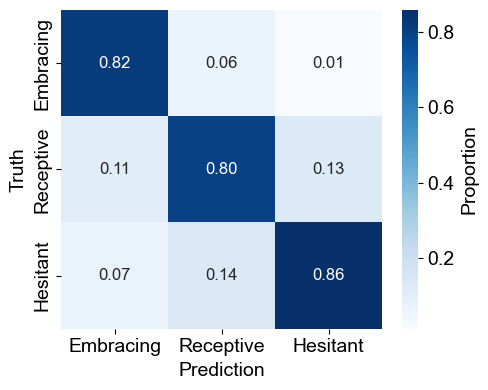

In [56]:
# 混淆矩阵
print("\nPlotting a confusion matrix...")
cm = confusion_matrix(y, y_pred_cv)

cm1 = cm / sum(cm)
print(cm1)

# 可视化混淆矩阵
plt.figure(figsize=(5, 4))
plt.rc('font', family='Arial', weight='normal')

# 创建热图并获取colorbar对象
heatmap = sns.heatmap(
    cm1, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    annot_kws={'size': 12},  # 设置图块标记字体大小为12
    cbar_kws={'label': 'accuracy'},  # 设置colorbar标签为accuracy
    xticklabels=['Embracing', 'Receptive', 'Hesitant'],
    yticklabels=['Embracing', 'Receptive', 'Hesitant']
)

# 设置colorbar字体为12
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Proportion', fontsize=14)  # 设置colorbar标签字体大小

# 设置坐标轴标签和刻度
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize=14)  # 添加x轴标签
plt.ylabel('Truth', fontsize=14)

plt.tight_layout()
# plt.savefig( r'CM_RF.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()